# Free Field Analysis Example

This example shows how to run OpenSees in DesignSafe from a jupyter notebook and how to postprocess the output results using python scripts, generate a LaTex report, and create interactive plots. 

A simple 1D free field analysis of a liquefiable soil layer is analyzed using OpenSees. An schematic of the soil profile in shown in the Figure. The soil profile consists of a 10 m liquefiable layer underlained by 20 m of dense material. The ground water table is at 2 m. An earthquake excitation is applied at the bottom of the soil column. A complyant rock is considered in the analysis.

The results are presented in terms of:

a) Time history of acceleration at the surface and corresponding response spectra.

b) Profiles of maximum displacement, PGA, maximum shear strain, and stress ratio

c) Stress strain plots for a point near the center of the liquefiable zone, and

d) Evolution of pore water pressure for a point near the center of the liquefiable zone. 

<img src = "schematic.png"  height="200" width="200" align = "center">

# Setup agave and start OpenSees job

In [1]:
import os
cwd = os.getcwd()
print cwd

/home/jupyter/MyData/freeFieldEffectiveJupyter


In [2]:
from agavepy.agave import Agave

In [3]:
ag = Agave.restore()

In [4]:
app_id = 'opensees-docker-2.5.0.6248u17'

In [5]:
storage_id = 'designsafe.storage.default'

In [6]:
input_dir = 'parduino/freeFieldEffectiveJupyter'

In [7]:
input_uri = 'agave://{}/{}'.format(storage_id, input_dir)

In [8]:
input_filename = 'freeFieldEffective.tcl'

In [9]:
app = ag.apps.get(appId=app_id)

In [10]:
job_description = {
    "name": "opensees-ex",
    "appId" : app_id,
    #"executionSystem" : "designsafe.community.data-01",
    "batchQueue" : "debug",
    "nodeCount" : 1,
    "processorsPerNode" : 1,
    "memoryPerNode" : "1",
    "maxRunTime" : "00:30:00",
    "archive" : True,
    "inputs" : {
       "inputDirectory" :  input_uri 
    },
    "parameters" : {
      "inputScript" :  input_filename
    }
}

In [11]:
job = ag.jobs.submit(body=job_description)

In [12]:
from agavepy.async import AgaveAsyncResponse

In [13]:
asrp = AgaveAsyncResponse(ag, job)

In [14]:
asrp.result()

'FINISHED'

# Postprocess Results

### Go to archived folder

In [15]:
jobinfo = ag.jobs.get(jobId=job.id)

In [16]:
jobinfo.archivePath

u'parduino/archive/jobs/job-01020102-70b7-4bbd-bc4e-9e73e0e9dadc-007'

In [17]:
user = jobinfo.archivePath.split('/', 1)[0]

In [18]:
import os

In [19]:
%cd ..

/home/jupyter/MyData


In [21]:
os.chdir(jobinfo.archivePath.replace(user,'/home/jupyter/MyData'))

In [22]:
if not os.path.exists('freeFieldEffectiveJupyter'):
    os.makedirs('freeFieldEffectiveJupyter')

In [23]:
os.chdir('freeFieldEffectiveJupyter')

### Import python libraries

In [24]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Plot acceleration time history

Plot acceleration time hisotory and response spectra on log-linear scale

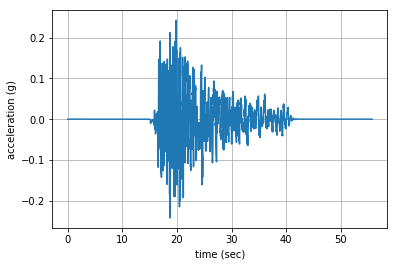

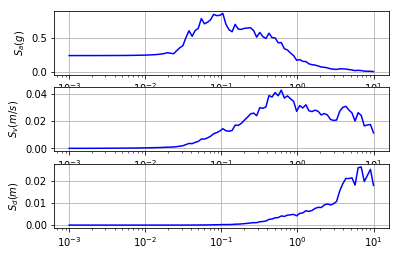

In [25]:
from plotAcc import plot_acc
plot_acc()

### Plot profiles

Plot profiles of max displacement, PGA, max shear strain, stress ratio and plot stress strain near the center of liquefiable layer 

In [ ]:
from plotProfile import plot_profile
plot_profile()

### Plot excess pore water pressure

In [ ]:
from plotPorepressure import plot_porepressure
plot_porepressure()

# Generate LaTeX Report 

In [ ]:
os.system('/usr/bin/pdflatex -interaction nonstopmode ShortReport.tex')

In [ ]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

In [ ]:
%pwd

In [ ]:
print jobinfo.archivePath

In [ ]:
pdf_fn = jobinfo.archivePath.replace('parduino','..')
pdf_fn += '/freeFieldEffectiveJupyter/ShortReport.pdf'
PDF(pdf_fn , (750,600))

In [ ]:
print pdf_fn

In [ ]:
%pwd

# Create Interactive Plots

### Pore water pressure

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
from ipywidgets import  interactive
import ipywidgets as widgets
import numpy as np

In [ ]:
pwp = np.loadtxt('porePressure.out')

In [ ]:
time = pwp[:,0]
pwp = np.delete(pwp, 0, 1)
uexcess = pwp - pwp[0, :]
uu = uexcess[0:len(time), 97]

In [ ]:
nodes = np.loadtxt('nodesInfo.dat')
disp = np.loadtxt('displacement.out')
disp = np.delete(disp, 0, 1)
disp = (disp.transpose() - disp[:,0]).transpose()

In [ ]:
acc = np.loadtxt('acceleration.out')
acc_input = acc[:,1]

In [ ]:
ndof = 2
nnodes = nodes.shape[0]
maxdisp = np.amax(disp, axis=0)
mindisp = np.amin(disp, axis=0)
maxdisp = maxdisp.reshape(ndof, nnodes, order="F")
mindisp = mindisp.reshape(ndof, nnodes, order="F")

In [ ]:
def pwpplot(timeStep):
    Step = int(timeStep / 0.01)-1;
    plt.subplot(211)
    plt.plot(time, uu)
    plt.plot(time[Step],uu[Step],'ro')
    plt.ylabel('pwp(kPa)')
    plt.grid()
    plt.subplot(212)
    plt.plot(time,acc_input)
    plt.plot(time[Step],acc_input[Step],'ro')
    plt.xlabel('time(s)')
    plt.ylabel('acceleration(g)')
    plt.grid()

In [ ]:
interactive(pwpplot,timeStep = widgets.FloatSlider(min = 0.01, max = time[-1], step = 0.01))

### Displacement

In [ ]:
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 1]) 

In [ ]:
def dispplot(timeStep):
    Step = int(timeStep / 0.01)-1;
    plt.figure(figsize=(7, 8))
    ax0 = plt.subplot(gs[0])
    ax0.plot(maxdisp[0, ::2], nodes[::2, 2], 'b--')
    ax0.plot(mindisp[0, ::2], nodes[::2, 2], 'b--')
    ax0.plot(disp[Step, ::4], nodes[::2, 2])
    plt.xlabel('displacement(m)')
    plt.ylabel('Elevation(m)')
    plt.grid()
    ax1 = plt.subplot(gs[1])
    ax1.plot(time,acc_input)
    ax1.plot(time[Step],acc_input[Step],'ro')
    plt.xlabel('time(s)')
    plt.ylabel('acceleration(g)')
    plt.grid()

In [ ]:
interactive(dispplot,timeStep = widgets.FloatSlider(min = 0.01, max = time[-1], step = 0.01), continuous_update=False)